In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

experiment_name = "M2"
__RECALLAT__ = 10

In [2]:
class Experimenter:
    def __init__(self, experiment_name):
        self._files = []
        self.experiment_name = experiment_name
    def append(self, recommender_list, forgetting_list, parameters_list):
        for r in recommender_list:
            for p in parameters_list:
                for f in forgetting_list:
                    self._files.append("{}_{}_{}_{}.dat".format(r, f, p, self.experiment_name))
    def __getitem__(self, position):
        return self._files[position]

In [3]:
experimenter = Experimenter(experiment_name)
recommender_list = ["MFRecommender"]
experimenter.append(recommender_list, ["ForgetUnpopularItems"], [1.2])
# experimenter.append(recommender_list, ["NoForgetting"], [None])
# experimenter.append(recommender_list, ["UserFactorFading"], [0.99])
# experimenter.append(recommender_list, ["SDUserFactorFading"], [1.08])
# experimenter.append(recommender_list, ["MappedUserFactorFading"], [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6])

In [4]:
class Recall:
    def __init__(self, n):
        self.n = n
        self.hits = 0
        self.stream = 0 
    def update(self, rank):
        print(rank)
        if rank <= self.n:
            self.hits += 1
        self.stream += 1
        return self.score()
    def score(self):
        return self.hits/self.stream
    
class Position:
    def update(self, rank):
        print(rank)
        return (1002 - rank)/1001

In [5]:
# (top-1 score, where the correct item is ranked, rec time, update time)

defined = False
recallDF = None
uptimeDF = None
rectimeDF = None
for file in experimenter:
    metric = Recall(__RECALLAT__)
    with open("D:\\recsys\\flurs\\results\\{}".format(file)) as f:
        file = file.replace('.dat','')
        file = file.replace('Recommender_','/')
        data = f.read().split(')')
        data.remove('')
        recallList = []
        uptimeList = []
        rectimeList = []
        indexList = []
        for index, line in enumerate(data):
            line = line.replace('(','')
            line = line.replace(' ','')
            info = line.split(',')
            recallList.append(metric.update(int(info[1])))
            uptimeList.append(float(info[2]))
            rectimeList.append(float(info[3]))
            indexList.append(index)
        if defined:
            recallDF = recallDF.merge(pd.DataFrame({file : recallList, "Index": indexList}), on='Index', how='left')
            uptimeDF = uptimeDF.merge(pd.DataFrame({file : uptimeList, "Index": indexList}), on='Index', how='left')
            rectimeDF = rectimeDF.merge(pd.DataFrame({file : rectimeList, "Index": indexList}), on='Index', how='left')
        else:
            defined = True
            recallDF = pd.DataFrame({"Index": indexList, file : recallList})
            uptimeDF = pd.DataFrame({"Index": indexList, file : uptimeList})
            rectimeDF = pd.DataFrame({"Index": indexList, file : rectimeList})

recallDF = recallDF.drop(columns=['Index'])
uptimeDF = uptimeDF.drop(columns=['Index'])
rectimeDF = rectimeDF.drop(columns=['Index'])

697
62
239
722
870
937
750
922
825
219
603
889
127
101
923
275
633
965
688
872
113
798
656
214
961
208
80
586
884
400
927
738
877
401
855
190
119
412
944
27
732
843
286
46
111
798
492
58
50
23
166
504
138
200
880
613
203
248
94
109
123
429
758
243
946
219
792
918
721
928
811
454
230
137
63
887
145
140
72
698
186
182
424
903
768
751
331
286
98
462
103
823
935
181
293
96
207
879
869
60
152
632
609
526
565
905
87
676
943
125
210
677
544
590
142
44
873
77
953
119
977
950
910
963
841
932
952
928
920
881
867
646
204
237
559
781
583
142
110
184
999
210
0
434
746
672
492
973
130
384
668
587
303
303
745
879
240
705
959
919
880
298
789
61
160
84
86
36
872
770
81
821
895
964
906
913
187
685
892
432
81
907
952
126
808
88
374
208
414
107
187
794
115
108
47
935
131
491
680
81
115
173
30
96
83
925
187
863
82
815
839
183
298
274
253
226
46
89
79
586
62
481
832
296
144
315
819
626
535
764
802
29
593
86
435
368
678
496
221
197
310
300
306
888
842
812
422
829
74
239
838
609
966
872
930
407
783
429
155
89

524
908
818
335
250
68
805
547
951
79
380
901
846
183
780
682
594
311
935
449
951
907
913
422
649
306
638
79
909
894
761
965
166
786
636
728
781
64
161
413
214
738
295
919
825
519
236
861
305
416
170
361
332
206
712
720
591
506
733
807
187
925
489
671
373
264
610
278
408
975
452
489
338
843
905
459
376
798
905
149
900
839
650
595
637
738
381
446
345
656
148
170
568
163
428
918
885
74
303
392
897
811
462
906
651
955
959
245
925
939
935
960
905
780
960
763
805
910
553
586
915
98
100
260
897
858
867
432
210
867
233
385
216
737
743
771
811
210
887
168
975
909
259
76
320
984
867
84
101
922
926
976
156
445
365
924
975
771
819
541
907
283
86
928
746
858
940
694
951
907
552
652
978
720
909
859
687
663
910
383
42
361
107
787
948
912
804
923
796
973
717
174
729
577
208
930
171
291
201
222
879
964
85
41
810
878
832
77
617
135
219
840
212
825
122
310
848
645
238
152
506
649
234
969
967
383
761
412
143
828
908
131
916
935
210
928
212
509
874
665
922
934
929
57
724
324
280
889
782
847
868
318
808
93

458
112
429
843
640
706
396
339
658
645
37
496
156
443
776
952
952
794
955
189
184
909
386
569
223
544
144
783
776
107
299
88
915
496
77
781
720
792
127
558
907
347
111
923
872
927
16
951
884
100
229
416
919
103
323
881
884
952
922
897
687
101
817
174
845
842
558
840
832
289
916
865
425
646
877
969
422
613
932
476
654
866
911
771
255
454
852
150
348
476
930
185
896
888
740
488
913
266
697
935
955
844
188
939
101
84
770
220
146
887
573
891
614
34
245
77
265
899
107
170
768
978
957
129
898
861
116
95
926
937
293
951
210
109
149
395
589
74
901
80
956
926
449
854
485
794
908
440
960
507
298
820
731
956
957
930
632
183
752
851
681
878
42
942
555
822
204
884
840
886
740
770
174
239
688
136
939
619
153
386
74
699
830
83
661
96
248
115
388
909
81
168
856
134
826
508
34
185
225
108
149
65
132
791
123
877
789
135
468
81
297
869
205
57
226
845
73
102
91
85
915
817
808
719
288
784
871
879
894
828
129
898
277
652
251
929
862
633
103
729
531
83
618
334
775
203
858
742
316
612
914
92
111
880
897
897


114
800
408
429
895
315
838
924
489
638
220
139
314
372
640
801
64
63
110
654
328
718
247
899
715
291
777
303
520
935
335
460
714
783
832
325
110
37
118
804
276
899
405
831
430
120
907
159
890
291
534
534
606
274
251
94
208
125
99
265
345
212
77
695
486
267
664
901
132
389
114
171
66
268
602
178
428
829
748
173
337
453
408
843
79
860
556
109
713
931
927
928
734
564
121
94
885
818
189
154
93
227
101
889
107
660
259
138
470
115
932
257
150
893
504
207
55
65
544
943
696
89
876
229
636
381
188
116
45
31
828
102
181
267
201
57
802
980
842
112
863
612
102
70
121
88
103
118
86
687
63
186
972
630
915
116
94
74
903
653
275
50
393
62
850
836
93
54
66
67
784
232
784
886
67
758
270
896
852
825
891
583
942
155
776
616
817
913
90
285
223
68
77
880
964
202
150
219
33
95
407
424
543
80
932
880
134
580
424
452
947
223
104
385
457
466
956
94
932
923
223
751
540
792
206
936
166
823
888
898
475
171
532
473
175
223
818
143
914
98
938
213
122
939
598
849
191
943
594
390
525
155
750
851
105
955
91
751
833
77

851
240
769
586
700
57
381
85
163
91
857
828
899
310
69
47
73
935
211
494
294
937
123
774
24
27
128
697
44
95
30
561
662
858
396
955
314
425
764
667
882
74
323
130
926
118
276
804
842
193
673
925
99
969
944
134
784
799
160
138
849
943
229
820
701
953
27
685
247
959
57
62
90
659
879
46
162
957
951
666
820
594
929
188
436
64
650
137
272
349
914
355
222
239
194
794
396
144
924
819
745
786
208
778
251
198
71
949
842
188
660
43
194
444
34
439
323
481
711
933
881
965
944
884
909
918
885
239
881
935
952
774
99
952
821
120
516
933
727
654
795
871
807
146
70
348
750
592
227
95
191
351
760
932
34
19
774
110
130
9
924
937
914
245
948
102
845
717
97
919
968
621
941
469
796
87
360
82
955
961
922
909
540
881
448
112
909
131
926
476
930
974
974
826
948
98
65
294
932
910
392
627
907
878
804
893
529
691
860
251
121
876
579
143
363
246
785
65
93
479
836
101
106
671
338
683
888
767
95
821
298
136
798
835
156
914
921
601
41
702
63
66
106
818
94
841
894
41
284
111
821
933
356
657
155
175
764
97
927
887
910

198
264
588
230
944
739
890
104
778
857
892
87
82
734
113
574
890
73
890
271
224
835
844
936
896
874
176
907
223
787
918
847
551
875
788
906
563
301
74
241
916
543
80
478
816
186
878
163
197
958
243
884
815
690
788
704
565
345
916
736
883
855
75
86
782
103
272
790
266
523
296
792
878
66
182
840
109
384
797
188
859
64
938
56
88
869
820
947
190
31
249
80
666
204
135
580
938
695
67
45
958
953
610
914
211
36
34
134
215
310
236
521
197
369
86
117
182
869
433
160
770
52
793
106
109
199
176
952
905
813
981
916
890
24
767
228
909
923
127
206
139
664
176
891
637
769
892
750
941
104
58
594
854
84
799
86
161
542
899
195
190
555
67
754
941
245
811
767
52
103
110
112
145
554
543
932
216
805
573
995
49
923
185
120
793
507
209
793
866
177
894
41
58
388
113
178
900
397
796
856
75
432
106
674
894
655
172
648
780
969
932
693
333
634
746
609
888
847
961
184
910
957
780
646
335
880
789
84
896
830
949
745
938
86
933
145
792
895
758
207
220
232
322
415
851
97
118
835
870
955
939
822
924
949
74
746
865
810
8

441
846
242
823
229
709
782
139
654
753
740
150
919
17
74
931
143
213
207
522
103
180
807
819
113
21
216
131
835
312
89
26
881
842
70
817
174
121
649
56
194
768
126
55
271
727
732
600
629
730
898
86
888
775
373
271
957
645
41
38
185
138
873
858
902
66
915
940
33
657
134
118
847
363
844
677
442
460
58
945
178
184
915
141
644
270
848
223
761
913
471
120
240
116
74
894
242
801
194
873
885
897
926
736
516
94
170
602
853
656
43
709
744
137
60
402
678
873
114
362
25
85
217
660
763
158
145
264
38
761
705
417
804
692
975
449
470
800
82
75
140
929
918
705
121
520
783
951
901
891
870
212
761
795
613
908
48
493
369
705
247
563
766
213
559
790
60
881
395
212
871
299
485
586
113
946
790
744
907
181
852
947
85
95
332
311
476
922
275
978
281
91
117
687
901
870
917
798
210
221
799
561
961
533
872
212
289
131
250
615
528
901
93
466
714
567
417
137
172
184
240
955
173
886
337
821
816
57
580
845
153
359
876
818
568
893
657
652
882
863
893
87
574
466
164
390
972
916
64
319
123
913
937
665
176
882
289
825


941
866
107
52
343
763
85
753
803
787
516
623
216
63
139
160
102
460
651
234
151
328
158
195
166
534
980
974
691
82
590
560
705
651
786
54
892
907
320
932
909
905
946
953
61
922
32
525
179
757
125
319
146
825
865
870
891
23
809
413
864
204
182
869
72
706
530
818
49
872
674
912
793
37
594
86
68
870
641
918
134
328
145
330
368
810
170
62
157
946
833
104
675
712
812
368
798
868
391
170
941
867
821
200
128
252
74
136
944
752
947
476
132
843
201
919
27
175
499
943
64
66
975
364
116
131
83
323
742
317
653
871
985
829
156
167
824
920
788
804
46
913
913
894
248
395
170
528
37
301
228
619
199
919
742
110
827
709
550
959
123
273
631
605
420
639
937
306
783
822
203
41
165
393
798
828
798
133
779
832
51
73
435
324
505
811
30
285
59
891
911
258
897
220
876
796
47
201
231
765
138
845
954
466
90
771
303
202
491
541
224
28
41
120
605
530
982
798
895
131
796
243
773
74
479
910
955
826
868
277
491
934
52
926
154
682
948
921
461
100
151
950
425
297
658
418
127
849
200
891
144
181
280
179
749
49
927
786
9

90
20
96
43
47
46
640
972
915
32
203
836
556
16
655
621
782
46
25
788
894
60
53
115
58
70
202
122
799
44
937
921
163
790
638
372
582
921
857
25
31
972
881
260
957
963
62
16
496
167
844
73
775
912
649
86
73
815
54
940
393
901
833
217
947
92
972
972
106
575
86
895
823
158
918
634
658
837
815
132
722
121
55
837
932
292
24
695
807
852
873
778
128
404
621
87
114
841
69
895
144
76
221
858
72
48
485
923
964
116
927
81
78
155
927
69
579
859
374
124
465
32
277
189
41
165
923
162
913
68
172
810
120
119
782
602
92
965
922
702
490
958
965
443
335
312
918
874
114
799
763
951
524
441
487
72
858
814
958
307
486
238
958
337
981
749
913
971
893
270
928
812
253
843
937
943
239
846
728
198
98
82
58
277
354
263
812
33
139
947
900
973
739
936
788
61
108
434
899
27
676
925
164
982
240
173
716
306
912
604
931
337
721
879
95
929
543
165
579
127
597
276
179
971
934
951
960
897
246
771
912
750
766
952
336
768
654
43
927
635
67
153
637
771
826
126
59
931
674
506
175
934
364
300
972
893
784
620
807
186
774
162
85

988
957
868
570
875
70
876
34
954
621
530
234
975
981
962
36
934
803
513
580
573
270
972
50
229
590
731
137
55
917
46
886
742
560
148
899
95
242
405
118
107
73
845
808
941
732
44
829
720
252
876
168
486
924
915
959
745
910
978
175
883
134
257
83
965
749
91
912
931
934
174
893
97
801
100
953
515
865
87
447
811
514
720
915
636
882
23
942
846
74
210
205
457
836
923
41
57
821
49
888
68
203
216
16
59
823
230
853
254
193
146
923
850
932
496
912
85
198
143
348
52
947
131
153
752
943
455
943
950
789
48
240
128
714
363
913
138
65
368
698
778
351
105
823
21
239
973
961
860
275
816
618
307
53
198
815
82
662
613
128
57
59
801
294
106
232
966
878
889
861
60
57
82
31
959
895
466
666
69
199
45
875
774
840
803
693
867
651
155
267
837
737
238
94
609
380
947
27
107
891
856
75
437
504
153
120
569
822
939
125
114
909
438
107
882
127
886
450
61
574
207
274
532
935
53
899
875
403
749
504
134
47
555
236
101
912
330
23
164
255
61
807
131
918
139
157
43
890
806
177
26
11
152
71
107
782
661
752
324
241
802
92
1

773
824
61
0
999
37
769
309
914
196
62
198
465
498
160
854
526
546
730
561
178
368
402
474
538
62
747
680
712
194
956
579
749
460
663
749
212
822
683
24
710
534
944
939
950
404
727
324
174
630
81
39
78
961
834
813
934
49
102
82
426
617
559
56
781
465
83
380
748
595
473
796
223
832
609
395
555
450
319
436
46
46
64
315
744
652
77
588
480
1000
283
908
390
300
927
483
980
33
76
981
961
165
662
260
213
122
229
515
257
153
969
75
245
925
515
510
483
674
538
693
72
71
272
140
298
489
105
610
805
314
811
283
749
786
701
392
1000
868
496
13
483
195
873
656
622
355
543
130
127
881
560
973
671
463
777
148
567
694
64
182
565
1000
862
476
380
771
911
32
293
630
107
777
534
508
909
783
0
183
893
933
317
425
311
808
42
383
618
939
668
835
167
58
848
677
32
928
82
515
273
167
285
902
907
643
430
68
721
48
935
365
801
456
27
936
516
32
920
870
767
173
893
140
427
103
167
877
220
68
670
602
89
722
947
184
625
664
793
160
220
723
65
48
994
348
976
641
237
79
147
976
578
287
829
822
714
148
98
609
228
933

192
71
605
78
548
459
133
55
204
401
889
945
824
577
165
312
815
909
818
141
926
122
907
764
808
824
128
153
214
110
943
47
918
898
302
180
876
793
894
829
97
949
688
908
636
459
640
306
153
130
183
864
116
936
783
884
945
905
321
354
1000
753
128
702
180
103
181
812
253
539
126
903
77
800
868
857
238
814
830
872
37
215
217
475
934
919
152
933
910
922
44
897
934
979
862
145
915
724
269
232
941
346
313
817
50
123
694
853
973
50
90
714
132
917
100
460
731
379
918
840
117
66
715
108
930
759
964
833
767
781
928
505
873
429
580
98
320
914
45
79
813
329
927
703
266
219
51
455
48
88
451
813
813
827
450
879
856
289
946
793
603
941
194
426
974
846
738
38
927
947
917
889
372
76
398
622
229
379
483
849
943
814
215
111
924
193
453
603
594
686
273
447
716
52
527
147
360
921
918
39
852
925
182
295
877
145
875
795
88
162
251
50
324
695
388
909
615
921
555
123
914
747
819
943
426
171
946
44
980
645
213
230
126
909
890
504
205
335
225
683
911
38
955
89
180
842
229
719
659
800
876
373
868
781
986
956
13

253
340
212
150
111
683
109
240
23
715
192
874
289
971
267
181
179
164
61
912
849
130
528
55
778
870
139
260
152
848
167
880
136
542
104
941
62
127
55
829
115
32
806
942
970
9
951
906
236
950
889
398
855
282
925
748
107
921
863
949
965
83
923
842
909
224
268
314
196
30
196
821
72
622
570
80
60
161
122
920
262
860
534
842
940
99
379
807
932
177
968
87
141
108
809
671
750
949
466
86
857
142
161
735
125
296
89
81
462
202
104
711
345
128
181
306
257
925
644
949
351
890
851
30
362
61
53
563
100
94
647
807
99
236
7
865
223
844
902
329
37
729
58
150
536
889
63
90
178
181
55
73
332
298
42
71
67
122
48
985
139
634
138
126
764
129
137
965
865
681
88
176
809
252
288
30
41
223
494
59
960
748
730
751
454
114
325
219
981
986
883
382
951
271
30
633
25
138
866
596
175
117
560
163
891
953
155
73
750
53
78
943
903
80
971
88
447
474
115
272
45
907
93
168
858
144
800
154
342
855
714
933
821
166
60
102
568
671
732
93
134
844
216
165
133
200
835
369
610
593
58
918
174
199
968
932
900
351
554
850
813
143
346

77
705
985
132
934
878
932
821
91
157
874
531
869
100
148
928
91
928
117
595
913
974
869
704
177
383
272
238
84
108
744
766
46
876
985
652
93
969
974
296
681
129
914
814
834
804
651
849
954
34
790
872
915
42
38
86
351
247
769
134
871
895
84
952
875
151
496
948
932
816
922
701
52
111
813
952
907
593
913
846
768
164
715
800
815
801
930
127
730
135
128
150
848
779
347
586
919
911
801
983
71
59
47
790
43
816
300
686
681
912
897
785
110
2
520
927
943
768
80
29
23
122
714
31
595
862
107
781
435
955
28
708
957
74
826
87
326
68
414
681
676
843
868
125
874
989
278
267
167
214
69
974
58
898
409
107
246
152
827
118
761
70
307
468
828
883
713
136
925
922
523
818
363
717
397
219
198
142
239
149
81
950
896
803
246
170
876
169
360
988
798
65
42
41
895
273
842
537
448
611
617
910
547
857
219
912
718
795
832
230
443
357
263
65
844
825
879
285
770
258
778
77
40
394
924
683
740
872
592
139
897
599
924
884
897
81
885
850
130
140
483
684
782
776
621
983
398
781
118
839
943
70
410
414
388
363
59
962
129
95


12
146
108
724
779
402
100
877
120
426
909
438
419
161
842
406
802
503
127
762
892
549
962
91
859
886
788
730
21
220
98
56
631
953
19
29
134
102
622
389
353
681
100
882
283
909
236
97
119
874
47
794
836
900
29
805
106
711
555
141
93
311
321
734
894
479
68
143
52
74
799
981
213
357
713
508
879
428
142
924
929
571
63
826
855
958
84
169
613
576
124
402
184
940
58
930
775
473
929
796
384
572
328
66
776
44
422
61
512
137
711
76
691
681
109
595
868
837
865
368
866
54
145
625
880
281
286
28
225
117
91
130
121
783
990
495
433
970
930
921
183
961
704
819
136
341
31
97
203
949
573
40
67
36
45
920
134
942
84
241
226
43
127
312
83
921
954
885
484
847
610
43
425
821
137
299
162
904
97
677
664
900
953
875
120
794
91
810
940
895
977
136
892
959
715
719
84
824
852
194
833
53
415
261
311
883
925
98
931
852
917
787
471
708
187
97
884
194
968
475
34
28
171
918
668
839
85
959
72
525
72
710
949
938
707
64
925
399
934
906
857
869
994
932
143
941
182
658
844
825
852
735
233
179
740
962
919
919
714
807
847
85

735
852
591
133
57
57
621
46
660
941
37
247
622
827
901
523
141
104
119
269
104
193
157
364
198
536
57
214
81
225
80
948
330
932
737
690
903
475
224
543
315
245
124
126
32
553
682
970
630
131
579
726
556
893
68
863
806
946
735
893
696
55
911
381
167
808
701
763
108
921
899
317
768
952
905
312
882
142
232
76
908
447
889
858
864
117
647
898
873
912
764
911
907
906
526
208
771
927
887
484
882
962
947
946
924
873
909
96
927
884
344
454
855
187
901
706
45
84
837
900
36
444
194
914
953
368
199
869
91
383
935
475
72
419
852
853
559
70
44
851
256
935
70
98
571
36
101
212
863
385
381
78
49
864
90
72
211
144
288
942
949
891
636
849
702
329
137
221
799
853
905
915
121
76
52
750
792
137
858
845
870
908
709
293
956
805
803
681
830
652
223
904
899
586
722
206
96
127
830
640
965
684
821
937
971
750
908
681
677
43
790
864
52
882
526
923
596
101
932
861
770
829
914
956
514
819
837
907
825
210
935
956
945
862
179
940
894
706
632
855
473
902
905
789
537
946
838
786
920
970
94
455
991
799
949
736
841
562


230
898
494
927
780
759
160
937
915
855
136
240
346
390
67
148
61
110
920
463
435
620
882
912
268
26
187
419
642
932
796
987
24
130
259
1000
363
964
88
415
512
567
739
180
291
62
957
358
808
588
578
299
350
83
190
30
135
406
342
832
243
740
198
902
894
971
121
181
88
56
965
120
81
204
932
885
930
427
444
538
877
428
293
185
817
229
840
292
346
642
414
951
955
915
115
906
477
59
430
197
89
887
858
647
656
428
152
871
598
917
596
308
904
631
506
920
720
879
933
70
959
211
78
343
493
770
898
473
800
504
790
257
126
540
128
45
315
938
903
860
173
321
463
723
949
615
122
917
85
199
784
824
415
350
956
371
75
535
947
925
789
920
296
134
100
926
768
84
112
844
132
180
67
78
444
647
752
904
91
70
92
824
158
151
434
548
547
771
66
215
689
568
781
165
914
637
812
833
794
664
926
829
854
606
611
803
865
719
934
623
739
159
932
924
807
870
541
381
950
958
552
929
925
778
935
112
60
100
905
120
126
463
605
114
395
55
101
778
772
368
767
26
381
301
889
182
679
844
144
781
265
432
162
46
869
419
965


33
687
311
275
921
713
609
293
708
252
929
925
89
637
949
835
205
36
353
635
46
51
960
927
536
199
303
382
71
834
326
258
296
837
150
944
956
886
294
949
647
269
657
247
152
14
973
991
129
419
927
46
474
767
949
424
693
79
637
682
854
677
155
246
275
54
843
61
51
70
952
244
300
820
122
150
336
131
872
158
437
495
699
853
394
639
324
137
130
626
473
770
655
88
305
163
897
905
731
546
445
77
260
252
450
301
820
962
953
282
372
910
905
348
58
915
924
936
962
933
829
939
145
886
447
579
481
27
888
909
848
819
84
244
446
747
581
693
938
849
921
361
848
254
780
927
837
886
840
897
791
192
164
105
92
680
276
48
177
96
189
856
795
896
301
698
832
834
73
810
62
312
452
499
750
959
968
583
842
520
902
884
700
108
44
18
50
59
267
67
468
66
949
736
709
816
777
268
934
254
693
134
863
943
218
756
110
733
852
959
279
864
522
452
19
55
43
880
12
105
557
66
533
24
849
930
52
886
878
193
60
299
79
744
787
973
114
299
243
745
935
921
177
67
962
410
633
792
63
870
101
389
703
838
817
817
96
779
672
507
3

296
809
417
56
47
773
58
859
475
909
952
629
293
625
916
931
772
170
278
31
784
944
827
38
746
163
947
836
944
53
921
375
730
894
88
192
946
788
656
79
598
118
843
46
271
67
35
768
83
190
135
104
103
389
65
167
60
136
568
103
767
422
945
133
740
777
922
956
92
931
955
96
905
71
199
52
199
85
978
199
794
43
76
124
147
944
78
207
217
668
847
63
972
513
675
956
869
38
763
579
236
32
843
187
289
911
94
884
890
915
134
33
224
871
903
35
581
136
216
38
214
226
762
307
836
73
634
439
178
77
888
923
334
843
434
894
337
829
959
851
787
741
897
925
46
71
109
133
216
85
818
733
314
134
135
251
107
864
785
122
663
237
26
915
930
956
80
961
878
44
81
783
52
61
888
91
818
538
50
358
936
118
615
915
866
887
963
908
914
398
924
251
302
80
409
127
21
122
942
739
985
947
60
49
179
384
474
841
840
858
62
905
60
717
940
119
857
129
735
898
81
707
699
549
91
891
867
119
628
330
558
128
649
840
806
954
377
848
912
892
796
880
284
752
771
243
139
883
150
695
78
896
402
834
135
328
815
815
127
301
139
335
969

712
303
21
894
156
908
299
914
751
820
830
896
804
923
938
943
993
121
216
222
179
578
864
807
153
274
864
478
459
272
904
743
763
212
76
111
877
512
976
156
863
726
793
65
818
538
257
880
350
426
371
546
521
832
865
149
544
162
362
772
639
819
81
179
441
340
653
65
940
76
248
837
328
919
924
167
906
907
256
82
870
614
940
330
920
798
426
619
714
524
291
218
876
738
626
697
244
528
940
13
429
921
920
387
732
326
468
224
234
353
544
719
202
87
50
126
953
945
561
446
254
283
107
290
364
275
746
336
782
262
17
719
817
50
737
172
71
115
616
737
270
86
430
384
172
511
118
259
80
901
448
140
0
343
952
40
925
911
382
761
939
170
23
373
282
175
97
764
167
26
889
875
291
808
823
704
93
443
127
59
916
782
357
912
30
327
878
45
67
919
937
524
193
628
653
905
257
298
152
290
896
210
116
596
964
476
979
139
38
573
450
537
401
708
619
621
112
301
927
635
448
981
142
714
952
828
539
580
953
970
929
868
950
18
169
75
935
793
75
206
160
190
75
853
120
448
701
894
919
856
162
234
119
121
871
554
875
496

394
702
160
158
82
7
214
169
910
59
55
573
229
438
804
583
121
594
407
424
264
216
28
982
849
918
88
237
666
755
744
959
969
92
149
914
118
84
77
78
315
30
529
285
166
146
791
457
184
54
118
420
71
928
565
675
310
169
467
819
8
676
244
952
914
494
696
937
757
226
918
500
156
618
844
94
47
129
927
136
148
155
21
736
575
217
138
703
294
51
343
563
927
943
890
167
113
68
943
429
878
124
913
969
939
176
543
791
606
671
289
843
90
876
333
233
631
738
927
865
220
141
67
691
77
789
895
955
559
943
845
950
249
628
852
77
37
723
239
733
956
623
91
524
71
98
441
140
82
890
201
939
786
481
844
83
357
113
930
861
951
983
751
690
953
748
212
897
960
135
770
254
838
931
175
578
87
275
639
118
888
313
97
943
500
52
141
381
908
95
346
46
60
302
247
512
758
307
916
935
439
533
765
243
276
843
75
786
848
150
184
203
510
33
902
172
332
247
958
834
954
75
72
885
219
89
105
830
811
845
930
946
50
857
969
880
387
892
896
905
203
78
843
915
74
775
879
590
78
133
116
981
834
700
590
104
908
901
50
879
861
935

57
626
173
710
51
927
888
65
812
29
39
141
519
105
811
873
36
960
460
26
256
75
352
46
386
61
42
955
45
28
950
950
43
69
885
70
936
178
818
859
911
165
956
159
229
266
53
175
235
174
53
982
173
923
934
981
953
966
70
58
811
820
868
918
930
204
795
21
514
112
952
202
343
996
120
99
114
256
164
80
520
802
465
664
992
278
898
959
976
945
391
63
57
920
954
211
788
960
940
947
140
46
56
315
985
943
893
394
185
850
61
139
811
64
31
946
93
146
85
786
854
297
332
919
274
899
835
177
867
50
62
794
461
658
87
936
771
771
718
103
793
975
230
974
27
47
34
241
26
518
929
555
149
42
892
41
914
124
196
109
713
167
908
849
914
975
195
585
18
943
102
828
797
160
347
888
85
53
162
236
815
448
72
931
908
461
956
639
906
662
893
750
97
697
848
234
655
24
696
963
980
23
954
719
943
149
123
902
29
540
627
951
952
275
752
114
301
891
219
322
910
322
533
942
226
264
916
147
144
872
947
885
920
894
186
75
928
887
968
904
27
143
97
847
938
749
924
217
828
186
146
956
810
481
179
948
938
743
45
933
972
764
934
5

879
28
308
931
85
57
38
62
874
148
908
48
881
668
185
839
544
926
980
791
719
129
35
823
947
243
207
809
127
62
539
23
91
330
131
300
642
248
191
50
742
699
214
158
201
659
209
924
825
624
339
867
26
839
939
126
94
934
953
893
895
307
570
694
233
885
130
446
580
74
37
50
296
832
429
554
47
222
91
135
930
142
52
271
985
453
383
528
806
188
663
117
113
50
128
825
140
74
806
297
103
158
152
293
851
924
178
886
36
901
80
936
939
592
809
958
259
148
81
907
74
110
104
89
88
640
80
605
893
200
112
39
753
210
873
841
81
17
901
439
285
880
121
970
42
491
948
907
819
761
911
531
892
893
784
915
644
938
659
545
201
186
870
871
158
924
50
35
437
33
957
424
893
285
783
41
302
21
106
866
969
208
46
853
765
850
798
880
133
207
140
939
480
820
393
884
234
163
917
881
607
910
204
800
729
383
861
929
758
66
317
116
270
272
304
85
576
864
154
256
88
673
427
858
835
32
860
194
47
428
230
82
913
862
933
971
922
743
126
94
59
42
24
370
871
927
114
116
73
346
387
230
18
409
87
348
904
475
118
879
939
55
844


275
345
626
141
795
178
85
164
21
96
32
933
33
755
108
278
943
468
911
232
116
29
777
94
968
850
94
201
192
551
934
5
105
561
57
93
806
972
762
773
41
829
842
711
147
16
134
951
245
256
943
193
286
837
745
230
139
19
813
817
772
933
66
385
79
27
106
408
67
113
47
95
897
694
131
199
900
23
63
14
265
111
907
926
935
66
74
116
892
28
81
106
735
202
150
749
40
392
198
316
790
764
855
360
912
376
312
644
24
543
125
121
877
912
857
54
64
915
181
849
957
922
109
646
73
221
595
834
732
172
957
914
152
83
794
615
22
94
872
128
22
578
515
889
869
661
128
884
344
904
907
880
95
44
150
34
477
40
682
946
845
130
935
485
358
706
39
542
844
796
709
734
918
62
303
874
60
164
441
163
982
71
125
369
282
117
851
671
41
91
185
928
199
662
965
37
780
794
760
572
923
345
595
537
771
981
643
392
579
943
75
312
913
931
913
692
29
819
883
944
871
476
464
258
181
863
37
13
79
86
230
885
846
45
784
916
877
795
755
217
841
902
215
760
625
917
961
178
539
77
977
438
145
158
870
749
36
512
450
745
962
319
947
886
1

625
596
666
934
306
236
755
888
946
824
93
254
790
643
885
877
230
42
978
825
488
912
618
532
827
956
530
991
650
31
134
927
856
172
917
790
243
466
879
556
81
935
883
956
918
742
956
187
797
898
886
72
837
274
178
816
487
770
189
137
96
248
259
108
52
798
791
898
420
931
853
86
787
865
970
41
38
757
39
47
100
118
272
279
733
167
774
16
755
833
882
175
996
714
599
288
916
804
928
162
815
565
942
276
906
971
879
477
304
166
94
838
874
805
554
907
170
823
291
706
805
296
526
536
334
242
863
771
610
141
764
871
887
48
101
716
951
61
677
914
534
111
118
273
148
891
156
903
854
891
24
44
828
133
891
930
840
943
879
821
302
323
900
960
840
916
890
120
828
625
147
94
28
835
123
62
976
951
55
796
946
661
38
914
762
628
939
97
972
568
889
323
122
306
142
936
892
975
777
676
213
773
219
692
39
23
68
527
903
911
324
101
794
667
683
235
885
942
718
584
454
145
159
128
541
665
324
431
781
947
187
405
862
39
961
308
932
147
924
17
927
913
86
831
99
0
974
232
358
264
812
23
83
255
902
32
635
172
78
8

860
944
206
941
389
44
83
765
868
49
521
456
943
912
260
321
131
928
975
882
924
546
357
104
893
246
151
513
89
179
80
825
871
291
916
135
523
123
17
220
830
470
90
719
163
77
976
781
121
120
9
728
625
20
971
153
221
89
211
870
897
938
893
24
972
964
403
989
123
200
82
115
816
76
900
68
731
692
783
14
171
162
207
40
58
71
918
796
25
20
120
767
753
701
23
135
276
81
277
74
89
168
965
522
713
17
246
951
238
859
117
25
172
256
37
824
62
687
816
924
863
600
881
100
104
13
48
86
53
22
15
136
89
120
715
948
73
926
987
178
160
47
644
478
293
197
42
111
498
150
890
42
885
211
977
414
109
230
643
887
811
183
168
411
722
324
401
85
857
937
918
955
760
69
878
980
895
970
982
897
86
920
912
938
134
805
880
817
609
919
416
290
427
184
763
762
958
114
980
921
172
919
895
712
91
109
895
969
150
732
209
184
948
927
930
983
122
177
853
986
41
952
253
125
795
987
817
113
94
973
980
867
692
47
166
84
946
915
85
744
396
158
848
83
655
931
87
109
142
816
46
269
162
167
809
84
237
48
779
908
94
68
573
455
8

63
113
268
243
802
595
655
583
132
863
78
923
981
900
788
910
376
771
803
671
189
818
150
224
954
114
63
790
951
876
414
548
488
820
67
830
92
758
59
974
875
970
911
134
880
580
363
905
921
83
929
49
288
692
222
124
189
234
114
957
72
908
794
352
74
267
257
15
223
722
49
962
112
314
884
772
77
802
212
440
848
185
84
241
825
710
870
636
610
228
68
942
493
708
285
377
31
394
959
838
96
850
911
181
933
726
937
878
900
99
14
970
852
60
854
926
926
872
400
894
793
86
760
83
66
703
969
74
446
865
703
379
566
674
828
842
190
310
896
950
959
905
947
175
186
891
230
876
49
48
778
737
923
552
956
805
820
54
56
107
943
160
837
421
189
485
136
217
207
289
807
364
918
49
932
704
405
905
783
205
156
838
50
732
173
786
524
329
974
977
936
848
49
129
634
48
94
922
44
126
953
849
60
939
58
146
862
966
143
892
103
403
567
947
760
149
97
451
550
909
189
969
823
396
58
758
865
613
783
872
496
67
978
960
64
28
49
215
307
832
132
964
877
53
895
920
37
805
717
77
313
954
800
99
392
706
505
908
856
63
42
841


917
943
770
453
462
103
33
39
412
89
26
66
53
89
101
979
910
917
571
210
954
59
64
405
848
106
154
849
907
274
608
952
61
414
435
585
991
955
919
919
38
70
838
131
823
402
856
194
63
378
928
927
212
957
621
112
891
876
869
924
160
547
950
967
557
656
924
703
369
955
262
934
570
61
609
448
976
103
940
939
937
172
134
434
902
396
810
183
251
236
954
938
324
246
355
882
265
986
426
913
883
326
134
641
955
176
20
196
76
50
946
461
947
539
127
170
798
663
680
198
869
336
834
806
709
617
866
52
905
443
20
350
188
262
234
970
78
83
842
655
840
686
677
848
982
167
86
815
952
18
787
32
742
922
640
386
92
43
68
777
766
806
857
168
81
112
800
960
60
98
950
280
305
94
16
96
765
740
168
874
879
820
764
50
179
30
956
961
96
27
179
45
44
967
821
620
73
633
743
864
531
898
880
127
859
227
919
849
769
45
576
55
37
31
811
320
689
61
317
85
95
107
450
126
52
863
957
775
161
910
72
484
16
180
41
70
851
34
964
130
925
557
906
904
75
881
761
289
263
623
147
319
612
145
768
538
222
851
912
175
48
887
93
770


422
231
175
954
144
97
921
922
976
254
182
111
51
115
763
706
63
866
915
74
249
688
332
149
887
635
69
110
56
75
55
903
45
867
964
937
271
291
102
164
62
162
840
880
925
127
906
216
420
919
885
385
800
43
403
910
779
134
830
27
27
797
242
163
845
134
222
231
308
815
922
68
17
59
15
42
463
859
42
212
807
68
56
217
49
873
45
168
784
759
843
421
618
586
102
250
36
729
603
313
924
75
66
435
400
340
883
444
433
34
773
809
364
773
979
466
882
87
302
77
105
667
876
915
831
250
263
120
131
67
44
40
151
82
242
961
243
825
371
19
55
939
445
431
157
314
934
206
150
981
794
794
535
181
237
837
50
545
748
840
922
148
827
920
357
949
114
770
826
145
199
901
942
163
315
51
907
245
99
79
359
818
308
855
39
631
22
497
830
119
95
800
90
879
899
425
965
841
438
759
937
927
831
208
616
945
70
392
971
916
843
388
873
689
844
513
866
676
863
157
152
962
580
795
725
41
876
648
846
714
940
908
130
875
58
697
953
365
51
774
797
866
953
112
860
896
54
796
88
948
707
98
731
943
713
44
936
978
836
885
110
898
944

743
39
896
123
259
262
337
57
471
983
923
238
683
743
31
320
74
47
728
932
815
432
666
38
624
383
41
946
693
166
36
65
436
72
387
832
448
934
96
64
687
348
39
842
846
29
602
797
76
56
198
889
939
814
53
859
558
81
112
843
724
915
818
213
138
814
768
155
468
183
169
859
52
942
525
92
865
369
103
874
809
99
84
733
922
139
218
37
62
746
662
653
775
821
800
841
326
178
898
534
153
972
197
80
202
903
601
35
334
409
392
935
878
579
742
928
801
940
183
830
54
578
147
77
526
509
877
49
46
209
389
261
947
80
351
939
960
80
68
165
699
678
20
208
122
53
696
758
74
38
57
806
118
61
322
292
52
898
599
75
853
86
55
701
338
90
95
942
929
82
35
23
929
905
227
934
926
948
84
68
98
17
804
53
158
973
937
186
192
659
123
724
12
811
337
112
52
921
138
93
521
61
101
902
103
269
858
21
910
951
39
294
449
452
289
161
115
232
180
57
951
902
717
97
321
886
74
57
886
728
101
131
928
905
929
877
72
693
574
902
739
63
728
72
677
620
822
148
920
539
361
852
322
788
840
459
918
434
53
918
621
919
949
627
964
845
893

931
530
756
907
856
511
945
776
473
886
710
350
845
136
56
634
438
478
930
355
911
55
828
31
814
121
141
712
927
944
913
851
749
916
367
368
306
33
131
166
528
178
13
552
40
32
945
183
128
463
750
576
638
604
87
311
48
214
644
74
50
20
824
31
156
73
170
882
771
891
211
141
215
30
211
391
469
818
50
21
231
97
75
527
68
306
975
961
971
877
975
868
991
796
423
42
410
659
513
945
822
975
14
26
933
796
909
970
832
405
857
946
43
846
763
970
802
983
884
920
49
936
884
945
121
36
67
986
977
650
964
988
948
117
162
74
648
971
847
138
37
20
207
388
988
24
814
747
859
272
777
942
929
77
939
161
423
673
720
899
96
830
173
979
618
58
902
929
388
60
76
822
927
58
199
82
801
773
572
325
166
879
228
54
90
48
489
896
929
23
450
967
503
916
87
93
637
901
921
903
218
544
703
67
156
78
588
115
85
853
982
965
157
630
892
175
177
181
834
925
70
515
333
753
647
907
38
93
915
973
366
109
949
40
705
357
912
747
950
379
793
442
742
113
200
958
529
41
409
563
354
203
88
969
793
814
969
671
179
910
740
41
620
13

885
482
960
917
365
472
569
543
928
73
345
725
740
732
417
929
274
455
735
796
549
129
469
530
60
819
135
614
904
530
943
704
879
201
139
919
75
855
436
749
44
777
603
56
53
928
667
492
901
984
940
976
622
81
829
795
892
61
711
40
898
42
73
120
93
37
49
761
275
277
213
85
729
808
904
683
335
442
316
151
310
371
936
804
35
931
39
137
219
125
334
907
551
453
875
165
231
778
953
864
67
831
102
666
961
48
123
544
124
849
589
148
79
336
46
267
245
899
832
25
36
300
67
38
948
111
116
74
186
40
930
65
90
79
460
920
342
216
727
277
574
75
646
202
146
89
946
656
80
77
795
36
808
74
118
80
212
57
695
543
698
985
353
32
881
911
937
893
60
50
128
789
150
841
391
161
66
719
287
963
969
159
142
155
422
919
297
378
560
534
877
217
278
458
246
681
620
68
72
10
56
872
86
802
607
848
856
59
880
843
106
942
24
838
104
157
175
671
244
557
922
286
922
57
379
816
942
601
415
173
15
116
175
69
901
135
9
946
102
175
220
875
66
184
835
945
250
64
12
511
396
58
105
119
854
115
29
269
901
862
257
939
407
869
832

963
895
50
50
978
72
778
977
417
44
958
982
731
894
372
940
33
345
217
590
470
691
119
509
250
973
313
951
179
723
709
26
985
94
905
856
469
404
931
416
357
573
654
778
382
215
896
949
163
562
150
299
703
219
914
382
76
964
108
84
57
124
915
807
192
259
106
956
135
899
113
167
202
630
156
944
991
809
832
45
818
791
713
870
698
49
85
940
987
565
902
73
667
96
471
927
940
191
183
800
44
246
616
705
78
924
119
844
123
904
582
623
517
241
117
892
372
227
136
889
874
484
972
332
755
378
888
774
894
878
229
728
184
957
726
809
448
900
676
132
928
896
871
208
67
912
189
102
55
94
586
44
182
290
735
71
847
152
139
154
441
674
253
218
297
119
278
361
767
464
765
264
285
106
781
87
213
243
109
163
969
899
46
306
403
41
138
808
948
973
23
739
530
22
734
164
291
16
53
42
844
405
983
60
49
123
329
22
860
17
939
707
121
959
928
164
956
69
46
41
780
896
27
962
41
40
934
717
182
824
725
849
85
341
947
881
341
46
942
51
716
778
832
858
640
926
86
884
44
687
712
135
776
751
417
920
921
468
855
317
785
2

894
99
903
893
396
140
123
69
942
738
784
3
946
49
213
835
858
899
886
40
70
717
782
75
935
466
827
879
69
169
232
197
839
823
42
78
655
142
209
402
775
984
70
950
178
23
177
866
851
101
202
241
26
872
880
738
400
928
844
769
164
907
60
923
272
268
199
555
895
882
975
891
152
253
815
801
784
414
973
93
675
411
4
76
961
46
694
920
710
472
955
28
891
888
632
937
939
140
310
559
816
341
197
429
818
478
265
37
682
227
251
933
98
131
688
30
900
875
971
966
354
41
100
61
971
61
216
216
716
937
28
140
817
981
978
107
824
49
957
699
923
194
178
846
110
76
150
73
861
251
47
24
127
18
657
958
26
248
521
108
816
74
157
105
901
912
135
946
334
820
80
33
826
473
85
786
449
682
902
420
226
802
23
935
213
872
778
883
221
496
99
202
172
926
207
479
68
754
916
942
843
139
105
27
906
817
913
88
894
898
257
83
349
98
864
661
117
785
696
53
154
56
849
33
918
603
159
959
169
87
88
374
25
66
23
238
112
633
28
214
963
783
141
21
80
786
32
227
800
141
540
538
909
916
775
13
957
966
995
356
734
110
436
35
63
8

46
42
69
566
528
340
256
789
78
38
916
75
296
939
112
711
260
887
727
910
200
969
177
135
832
634
695
521
826
615
138
466
322
151
713
30
224
139
115
918
49
928
956
862
214
739
100
764
902
4
36
30
262
31
162
287
975
904
140
591
877
555
376
236
106
97
971
825
953
949
85
930
807
922
938
959
827
953
136
188
960
965
582
48
531
48
940
64
805
35
63
332
126
78
901
193
782
383
659
954
843
147
902
257
896
737
716
731
53
833
289
333
894
208
18
830
36
146
762
150
842
730
953
75
957
775
851
832
758
942
945
88
347
371
825
119
540
617
777
176
27
534
319
724
929
734
124
902
704
556
85
321
369
670
253
95
237
120
124
768
634
384
179
867
822
563
138
121
55
187
324
44
341
141
949
872
888
406
873
107
254
297
7
48
678
849
168
983
798
682
131
985
63
68
103
473
101
847
565
899
175
143
311
846
226
265
492
478
42
880
257
948
178
415
976
475
874
83
729
785
933
871
903
218
501
191
473
530
932
362
863
924
87
310
772
847
718
258
421
118
224
489
188
941
742
860
184
838
843
767
803
683
316
444
437
713
438
106
182
166

255
730
456
787
86
862
668
507
686
439
847
958
871
118
795
169
175
40
862
890
397
456
373
133
303
727
97
126
493
866
56
869
78
827
807
968
212
132
721
405
686
685
33
467
84
573
692
138
555
183
517
70
211
299
210
20
465
323
56
73
29
745
640
105
81
969
647
580
91
192
276
916
79
392
468
982
758
863
858
942
985
924
951
873
915
816
164
25
73
365
825
247
930
74
82
985
235
912
91
364
295
36
927
333
103
104
44
549
286
407
56
826
218
858
392
934
716
226
94
587
1000
193
219
150
957
910
974
808
902
796
967
180
153
806
39
836
109
899
952
229
827
125
554
982
248
476
119
913
140
141
177
266
137
58
49
971
817
13
107
834
859
937
850
95
81
955
128
30
985
861
719
117
725
163
903
371
735
53
118
691
598
137
24
77
807
39
140
70
488
947
197
835
938
917
899
717
43
920
847
252
400
37
519
210
114
433
8
163
0
857
906
654
979
279
756
724
723
172
687
257
178
388
945
920
968
976
76
292
910
873
792
442
41
305
106
385
469
139
914
124
193
250
836
605
865
198
951
372
204
55
921
349
164
36
921
883
68
972
375
267
160
95

49
691
73
918
885
887
775
98
389
739
679
942
120
718
449
165
223
812
21
102
37
931
836
103
711
716
723
213
792
832
89
136
954
932
66
732
964
512
697
37
301
731
187
726
646
168
870
152
35
86
35
118
261
109
748
82
143
873
98
199
875
30
743
18
676
315
701
48
281
666
805
895
101
281
65
55
874
978
988
902
956
757
308
90
941
967
898
60
421
460
102
68
163
652
439
76
607
470
409
806
874
22
53
114
941
951
572
247
282
192
863
748
924
374
625
953
856
16
54
287
632
872
164
883
872
903
112
368
43
613
364
91
18
604
728
93
874
49
244
111
923
814
873
308
708
917
730
965
880
31
767
917
951
127
923
223
875
732
386
839
950
735
33
71
423
977
798
76
650
120
36
915
966
964
932
935
954
725
777
975
951
780
149
126
52
868
491
640
65
34
924
946
61
687
942
921
29
235
536
670
613
229
283
211
691
156
83
839
474
956
935
774
810
56
887
957
760
705
758
862
877
125
58
721
860
890
52
515
923
160
747
911
97
941
909
479
335
111
67
761
762
102
42
379
429
927
965
41
894
979
972
945
79
622
118
948
926
971
670
658
926
712
77

139
462
202
878
176
27
935
488
959
947
974
946
900
749
491
170
80
74
608
53
883
270
155
144
837
45
499
948
905
283
955
285
342
923
941
440
897
378
160
258
260
259
796
140
987
106
298
311
974
978
93
965
688
745
93
58
44
89
263
934
38
94
109
25
883
919
184
976
113
550
307
947
929
149
760
853
894
30
35
775
685
582
576
432
893
777
440
627
552
760
80
52
788
105
22
976
914
77
590
820
622
933
939
924
856
975
868
787
838
293
926
789
110
595
558
294
68
862
168
328
973
201
160
114
403
724
545
706
407
823
335
841
789
144
204
874
962
899
124
922
307
971
889
737
3
108
416
791
942
463
790
581
523
112
241
880
578
518
991
918
946
512
65
347
719
125
81
973
286
57
301
209
291
72
868
185
439
924
885
960
176
462
650
197
975
904
620
639
262
769
452
973
791
926
371
889
430
410
757
873
914
759
943
875
43
51
201
18
352
936
31
305
72
80
141
519
793
21
66
60
113
590
948
43
638
919
905
876
165
214
31
75
883
968
157
74
174
81
807
125
877
462
855
166
92
937
877
41
274
976
636
83
938
925
195
175
74
976
932
126
551


352
862
628
333
519
749
763
968
108
154
850
168
304
245
466
206
167
967
977
931
759
68
641
19
879
56
33
697
152
112
272
588
869
851
96
242
966
273
425
102
34
153
923
25
221
41
97
157
59
949
923
235
959
378
667
85
222
940
182
381
219
60
550
850
47
951
828
679
345
964
230
944
493
283
377
25
165
965
943
298
867
951
886
934
103
48
28
55
436
761
117
133
305
207
414
9
889
143
86
372
174
135
45
855
970
882
79
100
166
34
518
228
328
708
30
144
941
880
713
969
172
155
72
843
420
549
864
906
812
749
36
917
22
923
671
188
519
975
436
965
92
980
964
873
506
850
983
959
43
99
854
951
77
924
36
915
900
755
324
938
201
234
857
127
179
282
97
663
467
596
541
782
874
57
62
35
924
127
20
89
934
109
812
132
915
627
228
687
927
944
765
285
8
24
3
949
334
904
256
434
59
723
882
222
146
210
811
397
265
796
958
119
957
46
164
872
819
816
959
486
295
155
953
125
877
955
81
30
142
119
162
151
155
48
769
243
161
773
576
886
90
13
28
214
860
193
927
718
27
509
967
83
103
787
854
951
922
660
791
179
71
19
895
479

59
61
511
838
62
71
617
33
230
856
832
82
203
910
80
66
147
735
977
951
36
918
924
101
84
566
553
691
31
78
106
860
105
375
509
811
669
618
829
151
792
229
869
138
568
129
366
204
138
904
115
179
31
115
676
44
327
94
530
731
968
68
218
64
100
619
78
880
83
384
278
512
546
71
33
462
495
296
950
956
924
787
102
957
808
570
197
815
119
71
915
894
873
22
99
425
387
177
20
257
438
826
38
18
180
46
478
142
14
949
34
950
77
195
752
101
911
109
93
54
79
220
159
172
803
795
155
896
935
49
87
11
24
887
172
842
263
102
327
808
888
815
884
197
725
694
973
935
814
30
141
88
13
862
420
629
71
37
405
94
179
65
929
989
914
81
864
225
416
588
747
818
127
93
135
60
761
206
188
588
826
80
936
273
164
896
769
894
923
693
985
943
739
117
155
485
628
449
425
469
472
182
808
377
766
112
204
176
307
173
118
879
218
699
197
962
58
174
208
264
35
283
185
789
798
328
220
64
120
96
269
708
248
949
755
134
752
103
891
151
431
881
54
130
890
271
960
486
404
832
742
864
268
447
193
274
130
894
166
208
395
978
940
34

796
376
701
202
719
778
600
40
926
905
892
970
160
597
305
469
944
928
158
672
886
262
321
950
30
649
169
106
973
249
968
443
966
951
900
897
787
475
563
858
935
812
75
195
63
25
827
556
846
545
974
172
834
77
785
262
523
859
269
292
964
54
534
713
101
360
144
949
970
812
593
661
346
149
906
618
57
39
83
63
637
664
60
569
110
929
162
114
143
355
990
291
68
20
56
855
141
859
897
609
945
115
29
78
824
183
517
582
981
436
85
71
55
772
780
668
966
974
749
731
594
293
942
896
84
943
100
142
643
549
988
828
297
896
970
645
629
78
974
963
886
883
724
802
862
195
971
239
714
883
937
263
742
770
121
894
922
206
822
59
908
75
821
964
470
891
439
938
102
359
197
103
809
972
871
105
800
811
856
57
25
851
217
892
926
270
887
847
203
411
262
906
728
767
932
917
917
928
827
581
883
972
814
706
202
412
337
893
881
664
25
42
943
918
49
879
918
281
31
162
73
873
801
175
526
70
855
827
161
242
842
60
994
905
56
822
977
862
259
924
805
717
560
35
217
139
940
856
362
967
888
911
856
377
834
529
955
924
71


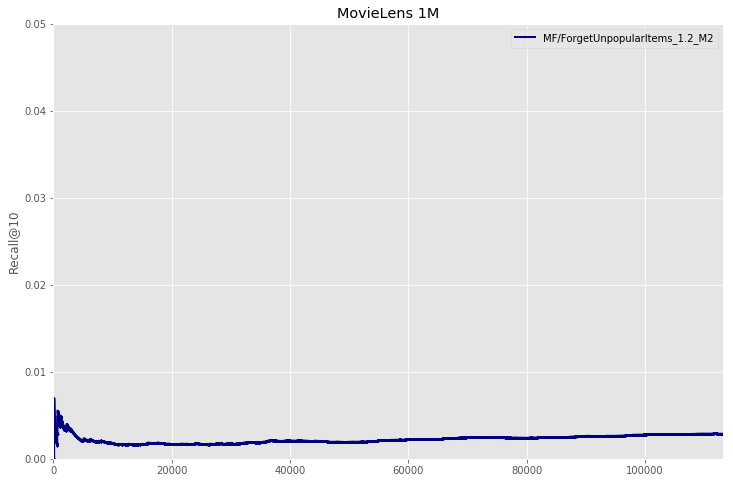

In [6]:
plt.rcParams['figure.figsize'] = (12,8)
with plt.style.context(('ggplot')):
    ax = recallDF.plot(lw=2, colormap='jet', marker='.', markersize=1, title="MovieLens 1M")
    plt.ylim([0,0.05])
    ax.set(xlabel="", ylabel='Recall@{}'.format(__RECALLAT__))

In [7]:
recallDF.mean()

MF/ForgetUnpopularItems_1.2_M2    0.002276
dtype: float64